In [1]:
import glob
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader
from torchvision.models.vision_transformer import ViT_B_16_Weights
from torchvision.models import EfficientNet_B7_Weights
from PIL import Image
%matplotlib inline

In [2]:
output_train_dir = "./train"
rate = 0.9

In [3]:
train_file_list = []
valid_file_list = []

like_file_list = glob.glob(f"{output_train_dir}/01_like/*")
notlike_file_list = glob.glob(f"{output_train_dir}/00_notlike/*")

like_index = list(set(list(map(lambda x : "/" + x.split("/")[-1].split(".")[0] + ".", like_file_list))))
random.seed(2022)
like_train_index = random.sample(like_index, int(len(like_index)*rate))
like_valid_index = [x for x in like_index if x not in like_train_index]
train_file_list.extend([x for x in like_file_list if "/" + x.split("/")[-1].split(".")[0] + "." in like_train_index])
valid_file_list.extend([x for x in like_file_list if "/" + x.split("/")[-1].split(".")[0] + "." in like_valid_index])

notlike_index = list(set(list(map(lambda x : "/" + x.split("/")[-1].split(".")[0] + ".", notlike_file_list))))
random.seed(2022)
notlike_train_index = random.sample(notlike_index, int(len(notlike_index)*rate))
notlike_valid_index = [x for x in notlike_index if x not in notlike_train_index]
train_file_list.extend([x for x in notlike_file_list if "/" + x.split("/")[-1].split(".")[0] + "." in notlike_train_index])
valid_file_list.extend([x for x in notlike_file_list if "/" + x.split("/")[-1].split(".")[0] + "." in notlike_valid_index])

In [4]:
class ThumbDataset(data.Dataset):
    def __init__(self, file_list, classes, transform=None):
        self.file_list = file_list
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        # 指定したindexの画像を読み込む
        img_path = self.file_list[index]
        img = Image.open(img_path)
        # 画像の前処理を実施
        img_transformed = self.transform(img)
        # label(分類) の取得
        label = self.classes.index(img_path.split("/")[-2])
        return img_transformed, label

In [5]:
# transform
# param
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
# compose
transform_train = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.2)
])
transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [6]:
# Datasetの作成
classes = ["00_notlike", "01_like"]
train_dataset = ThumbDataset(
    file_list=train_file_list,
    classes=classes,
    transform=transform_train
)
valid_dataset = ThumbDataset(
    file_list=valid_file_list,
    classes=classes,
    transform=transform_valid
)

In [7]:
# DataLoaderの設定
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# model loading
net = models.efficientnet_b7(weights=EfficientNet_B7_Weights.DEFAULT)

# 全ての層のパラメータを訓練不可に
for param in net.parameters():
    param.requires_grad = False

# 一部の層を入れ替え（デフォルトで訓練可能）
net.classifier[1] = nn.Linear(2560, 2)

_ = net.cuda()  # GPU対応

In [9]:
# # model loading
# net = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# # 全ての層のパラメータを訓練不可に
# for param in net.parameters():
#     param.requires_grad = False

# # 一部の層を入れ替え（デフォルトで訓練可能）
# net.heads[0] = nn.Linear(768, 2)

# _ net.cuda()  # GPU対応

In [10]:
%%time

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(16):  # エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i % 1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 0.5966143646965856 Loss_Test: 0.6179093023141226
Epoch: 1 Loss_Train: 0.4123333420442498 Loss_Test: 0.5592086861530939
Epoch: 2 Loss_Train: 0.352882066498632 Loss_Test: 0.4998522748549779
Epoch: 3 Loss_Train: 0.3362899791935216 Loss_Test: 0.4370410641034444
Epoch: 4 Loss_Train: 0.32315296129040094 Loss_Test: 0.3917834560076396
Epoch: 5 Loss_Train: 0.30022426273511804 Loss_Test: 0.33996984362602234
Epoch: 6 Loss_Train: 0.298280761293743 Loss_Test: 0.3445558821161588
Epoch: 7 Loss_Train: 0.2830317940400994 Loss_Test: 0.3094818989435832
Epoch: 8 Loss_Train: 0.2754741077837737 Loss_Test: 0.2941974600156148
Epoch: 9 Loss_Train: 0.2672889083623886 Loss_Test: 0.2870337093869845
Epoch: 10 Loss_Train: 0.29480466829693835 Loss_Test: 0.2839324325323105
Epoch: 11 Loss_Train: 0.25564794566320337 Loss_Test: 0.28584031263987225
Epoch: 12 Loss_Train: 0.25979124722273456 Loss_Test: 0.2824038515488307
Epoch: 13 Loss_Train: 0.2621526491382848 Loss_Test: 0.3015584722161293
Epoch: 14 L

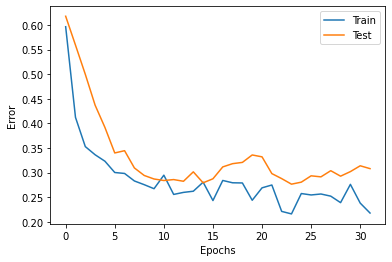

In [11]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [12]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 88.37209302325581%


In [13]:
model_path = 'model.pth'
torch.save(net.state_dict(), model_path)